# 1 Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from keras.utils import np_utils
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier


# Make sure you have correct sklearn version
from sklearn.model_selection import train_test_split

# Using the pickle module to load .pkl file
import pickle

# Make the notebook's output stable across runs
np.random.seed(42)

# Set up inline plotting and figure/axis labels
# Same as tutorial sheets
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tensorflow as tf
from tensorflow import keras

# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)

# 2 Data Preprocessing

## 2.1 Data Loading

In [ ]:
# Data Loading
# Read files in binary mode
with open('/content/drive/MyDrive/COMP5318/emnist_train.pkl', 'rb') as train_file:
    train_data = pickle.load(train_file)

with open('/content/drive/MyDrive/COMP5318/emnist_test.pkl', 'rb') as test_file:
    test_data = pickle.load(test_file)

x_train_full = train_data['data']
y_train_full = train_data['labels']

x_test = test_data['data']
y_test = test_data['labels']

## 2.2 Data Normalisation

In [ ]:
# Normalise: Scale the data to the range 0-1
x_train_full = x_train_full.astype('float32')
x_train_full = x_train_full / 255.
x_test = x_test.astype('float32')
x_test = x_test / 255.

## 2.3 Split the dataset

In [ ]:
# Split the training data into training and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, train_size=0.9)

## 2.4 Rotate images

In [ ]:
def rotate(image):
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

# Apply rotate function to each sample in x_train and x_valid
x_train = np.array([rotate(img) for img in x_train])
x_valid = np.array([rotate(img) for img in x_valid])
x_test = np.array([rotate(img) for img in x_test])

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_valid: {x_valid.shape}")
print(f"Shape of y_valid: {y_valid.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

## 2.5 Plot Some images

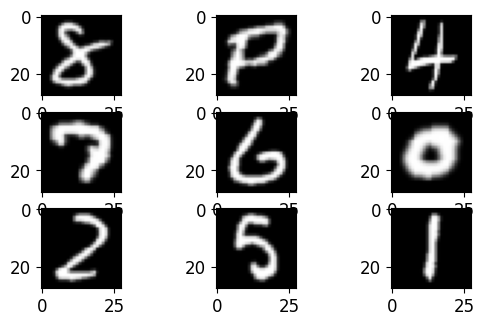

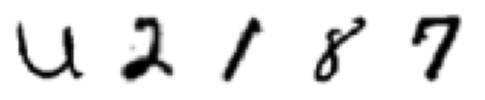

There are 62 unique labels


In [ ]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

    
def plot_examples(data, n_rows=1, n_cols=5):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(x_train)

# EMNIST ByClass mapping:

# 0-9:   Digits (0-9)
# 10-35: Uppercase letters (A-Z)
# 36-61: Lowercase letters (a-z)

# -----------------

# 50: Lowercase 'o'
# 20: Uppercase 'K'
#  5: Digit '5'
# 53: Lowercase 'r'
# 59: Lowercase 'x'

# 10 Digits, 26 uppercase, 26 lowercase letters.
print(f"There are {len(np.unique(y_train_full))} unique labels")

# 3 Classification Models

## 3.1 Convolutional Neural Network

In convolutional neural networks (CNNs), input data is typically represented as a tensor, i.e., a multi-dimensional array. For image data, it is usually represented as a three-dimensional tensor with a shape of (height, width, channels), where channels represent the number of color channels in the image.

In the code snippet above, the np.expand_dims function expands a new dimension to the last axis (-1) of the input data. This is because when using CNNs for image classification tasks, we typically need to input a four-dimensional tensor with a shape of (batch_size, height, width, channels), where batch_size represents the number of images in each training batch.

Therefore, we need to add a new dimension to the last axis of the input data to indicate the color channels of each image. This way, we can reorganize the image data into a four-dimensional tensor and pass it to the CNN for training and prediction.

### 3.1.1 CNN Data Pre-processing

In [ ]:
# Reshape image for CNN
# Add an extra dimension to our data
# To keep four dimensions -> [batch_size, height, width, n_channels]
x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_valid_cnn = x_valid.reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)

# One hot encoding
y_train_cnn = np_utils.to_categorical(y_train, 62)
y_valid_cnn = np_utils.to_categorical(y_valid, 62)
y_test_cnn = np_utils.to_categorical(y_test, 62)

### 3.1.2 CNN Fine-tuned

In [ ]:
def create_cnn_model(optimizer='adam', kernel_size=(3, 3), num_filters=32, dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(num_filters, kernel_size, activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(62, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Wrap the Keras model with KerasClassifier
cnn_model = KerasClassifier(build_fn=create_cnn_model)

# Set the grid search parameters
parameters = {
    'optimizer': ['adam', 'rmsprop'],
    'kernel_size': [(3, 3), (5, 5)],
    'num_filters': [32, 64],
    'batch_size': [64, 128],
    'epochs': [10, 20],
}


# Perform the grid search
grid = GridSearchCV(cnn_model, parameters, cv=2, verbose=3)
grid.fit(x_train_cnn, y_train_cnn)

# Print the best parameters
print("Best parameters found: ", grid.best_params_)

<ipython-input-11-b2748c09ef3a>:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn_model = KerasClassifier(build_fn=create_cnn_model)


Fitting 2 folds for each of 32 candidates, totalling 64 fits
Epoch 1/10
704/704 [==============================] - 13s 3ms/step - loss: 1.4432 - accuracy: 0.6133
Epoch 2/10
704/704 [==============================] - 2s 3ms/step - loss: 0.8460 - accuracy: 0.7410
Epoch 3/10
704/704 [==============================] - 2s 3ms/step - loss: 0.7021 - accuracy: 0.7747
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.6294 - accuracy: 0.7941
Epoch 5/10
704/704 [==============================] - 2s 3ms/step - loss: 0.5867 - accuracy: 0.8010
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 0.5566 - accuracy: 0.8110
Epoch 7/10
704/704 [==============================] - 2s 3ms/step - loss: 0.5307 - accuracy: 0.8181
Epoch 8/10
704/704 [==============================] - 2s 3ms/step - loss: 0.5110 - accuracy: 0.8238
Epoch 9/10
704/704 [==============================] - 2s 3ms/step - loss: 0.4922 - accuracy: 0.8258
Epoch 10/10
704/704 [=================

### 3.1.3 CNN Best Model

In [ ]:
from tensorflow.keras.optimizers import Adam

# Best parameters found:  {'batch_size': 128, 'epochs': 10, 'kernel_size': (5, 5), 'num_filters': 32, 'optimizer': 'rmsprop'}
model_cnn = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(62, activation="softmax"),
])

model_cnn.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

# Best model fit
history = model_cnn.fit(x_train_cnn, y_train_cnn,
                        batch_size=128,
                        epochs=10,
                        validation_data=(x_valid_cnn, y_valid_cnn))

Epoch 1/10
704/704 [==============================] - 6s 6ms/step - loss: 1.1653 - accuracy: 0.6747 - val_loss: 0.5348 - val_accuracy: 0.8160
Epoch 2/10
704/704 [==============================] - 3s 5ms/step - loss: 0.6100 - accuracy: 0.7997 - val_loss: 0.4588 - val_accuracy: 0.8361
Epoch 3/10
704/704 [==============================] - 3s 5ms/step - loss: 0.5244 - accuracy: 0.8224 - val_loss: 0.4433 - val_accuracy: 0.8413
Epoch 4/10
704/704 [==============================] - 4s 5ms/step - loss: 0.4865 - accuracy: 0.8302 - val_loss: 0.4200 - val_accuracy: 0.8478
Epoch 5/10
704/704 [==============================] - 4s 5ms/step - loss: 0.4579 - accuracy: 0.8377 - val_loss: 0.4046 - val_accuracy: 0.8498
Epoch 6/10
704/704 [==============================] - 3s 5ms/step - loss: 0.4352 - accuracy: 0.8449 - val_loss: 0.4066 - val_accuracy: 0.8525
Epoch 7/10
704/704 [==============================] - 3s 5ms/step - loss: 0.4190 - accuracy: 0.8485 - val_loss: 0.3977 - val_accuracy: 0.8563
Epoch 

### 3.1.4 CNN Evaluation

625/625 [==============================] - 2s 2ms/step - loss: 0.4172 - accuracy: 0.8527

Accuracy on test data: 0.8527
1/1 [==============================] - 0s 183ms/step
[ 9 43  3]


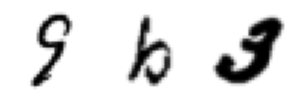

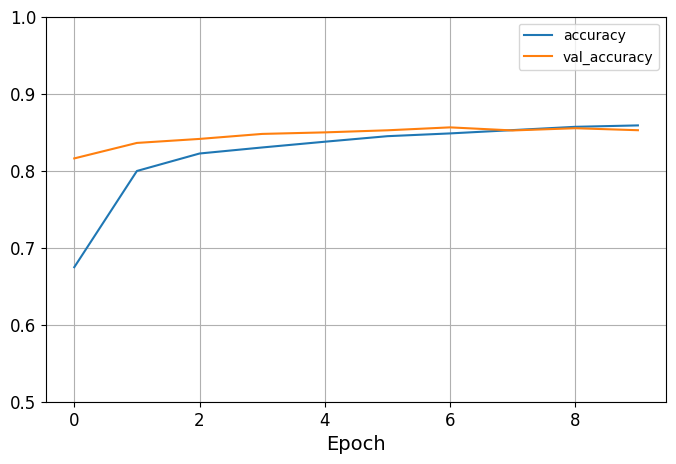

In [ ]:
# Evaluate the classifier on the test data.
loss, accuracy = model_cnn.evaluate(x_test_cnn, y_test_cnn)
print(f"\nAccuracy on test data: {accuracy:.4f}")

# Sample several test examples
x_test_sample = x_test_cnn[3:6]

# Get probability of each class from model
y_proba = model_cnn.predict(x_test_sample)
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)
plot_examples(x_test_cnn[3:], n_rows=1, n_cols=3)

# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.5, 1)
plt.xlabel('Epoch')
plt.show()

## 3.2 LSTM Neural Network

### 3.2.1 LSTM Data Pre-processing

In [ ]:
# Preprocess the MNIST dataset
y_train_lstm = to_categorical(y_train, num_classes=62)
y_valid_lstm = to_categorical(y_valid, num_classes=62)
y_test_lstm = to_categorical(y_test, num_classes=62)

### 3.2.2 LSTM Fine-tuned & LSTM Best Model

In [ ]:
# Define the model architecture
def build_lstm_model(units, activation,recurrent_activation,dropout):
    lstm_model = Sequential([
        Reshape((28, 28), input_shape=(28, 28)),
        LSTM(units, activation=activation,recurrent_activation=recurrent_activation,dropout=dropout),
        Dense(62, activation='softmax'),
        Reshape((62,))
    ])
    return lstm_model

# Define the hyperparameters to be tuned
units_list = [64, 128, 256]
activation_list = ['relu', 'elu']
recurrent_activation=['tanh','sigmoid']
dropout=[0,0.1,0.2]
best_model = None
best_acc = 0

# Perform grid search over the hyperparameters
for units in units_list:
    for recurrent in recurrent_activation:
        for drop in dropout:
            for activation in activation_list:
                # Build the model
                lstm_model = build_lstm_model(units, activation,recurrent,drop)
                # Compile the model
                lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                # Train the model
                early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
                lstm_model.fit(x_train, y_train_lstm, epochs=10, batch_size=32, validation_data=(x_valid, y_valid_lstm))
                # Evaluate the model on the test set
                test_loss, test_acc = lstm_model.evaluate(x_test, y_test_lstm)
                print(f"Units: {units}, Activation: {activation}, Test Loss: {test_loss}, Test Accuracy: {test_acc}")
                if test_acc > best_acc:
                    best_model = lstm_model
                    best_acc = test_acc
print("Best Model:")
print(best_model.summary())
print("Best Accuracy:")
print(best_acc)

Epoch 1/10
2813/2813 [==============================] - 22s 7ms/step - loss: 13.4918 - accuracy: 0.0503 - val_loss: 15.2860 - val_accuracy: 0.0496
Epoch 2/10
2813/2813 [==============================] - 20s 7ms/step - loss: 11.0949 - accuracy: 0.1153 - val_loss: 2.6560 - val_accuracy: 0.3139
Epoch 3/10
2813/2813 [==============================] - 20s 7ms/step - loss: 1.6206 - accuracy: 0.5504 - val_loss: 1.1550 - val_accuracy: 0.6597
Epoch 4/10
2813/2813 [==============================] - 20s 7ms/step - loss: 1.0159 - accuracy: 0.6912 - val_loss: 0.9070 - val_accuracy: 0.7144
Epoch 5/10
2813/2813 [==============================] - 22s 8ms/step - loss: 0.8312 - accuracy: 0.7366 - val_loss: 0.7682 - val_accuracy: 0.7533
Epoch 6/10
2813/2813 [==============================] - 23s 8ms/step - loss: 8.5844 - accuracy: 0.3731 - val_loss: 15.3145 - val_accuracy: 0.0498
Epoch 7/10
2813/2813 [==============================] - 22s 8ms/step - loss: 15.2890 - accuracy: 0.0514 - val_loss: 15.3202 - 

### 3.2.3 LSTM Evaluation

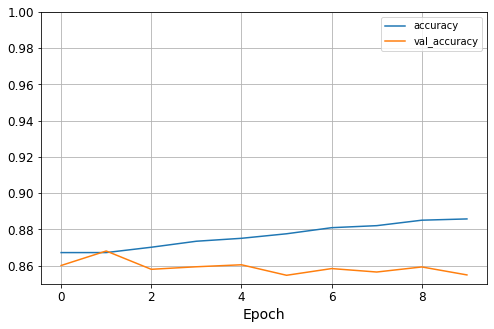

In [ ]:
import pandas as pd
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = best_model.fit(x_train, y_train_lstm, epochs=10, batch_size=32, validation_data=(x_valid, y_valid_lstm))

# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.85, 1)
plt.xlabel('Epoch')
    
plt.show()


625/625 [==============================] - 6s 9ms/step - loss: 0.4709 - accuracy: 0.8439

Accuracy on test data: 0.8439
1/1 [==============================] - 0s 36ms/step
[ 9 37  3]


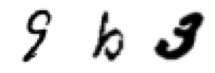

In [ ]:
# Evaluate the classifier on the test data.
loss, accuracy = best_model.evaluate(x_test, y_test_lstm)
print(f"\nAccuracy on test data: {accuracy:.4f}")

# Sample several test examples
x_test_sample = x_test[3:6]

# Get probability of each class from model
y_proba = best_model.predict(x_test_sample)
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)

plot_examples(x_test[3:], n_rows=1, n_cols=3)

## 3.3 SVM

### 3.3.1 SVM Data Pre-processing

In [ ]:
# Change from matrix to array --> dimension 28x28 to array of dimention 784
x_train_svm = x_train_full.reshape(100000, 784)
x_test_svm = x_test.reshape(20000, 784)

In [ ]:
# Scale the data to lie between -1 to 1
x_train_svm = x_train_svm / 255.0*100 - 50
x_test_svm = x_test_svm / 255.0*100 - 50

#I mod2 the label sets to have a result of 1 or 0 , for odds and evens respectively
y_train_svm =y_train_full % 2
y_test_svm =y_test % 2

In [ ]:
# apply PCA without reducing dimensionality, then compute the min number of dimensions for preserving 95% variance
pca = PCA()
pca.fit(x_train_svm)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

103

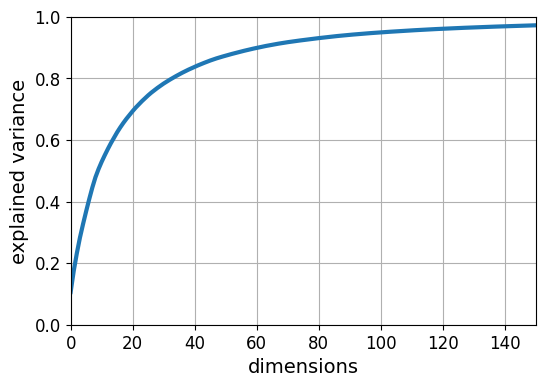

In [ ]:
# Plot the explained variance vs number of dimensions

plt.figure(figsize = (6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 150, 0, 1]) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

In [ ]:
# PCA
pca = PCA(n_components=103)
x_train_svm = pca.fit_transform(x_train_svm)
x_test_svm = pca.transform(x_test_svm)

### 3.3.2 SVM Fine-tuned

In [ ]:
# GRID SEARCH FOR PARAMETER OPTIMIZING
svm = SVC()
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]
              #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

print("grid search")
grid = GridSearchCV(svm, parameters, cv=2, verbose=3)
print("grid.fit")
grid.fit(x_train_svm, y_train_svm) #grid search learning the best parameters
print("grid done")

print (grid.best_params_)

grid search
grid.fit
Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END ......C=1, gamma=0.001, kernel=rbf;, score=0.751 total time= 7.1min
[CV 2/2] END ......C=1, gamma=0.001, kernel=rbf;, score=0.752 total time= 7.0min
[CV 1/2] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.728 total time= 8.1min
[CV 2/2] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.727 total time= 8.7min
[CV 1/2] END .....C=10, gamma=0.001, kernel=rbf;, score=0.776 total time= 6.6min
[CV 2/2] END .....C=10, gamma=0.001, kernel=rbf;, score=0.778 total time= 6.8min
[CV 1/2] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.748 total time= 6.9min
[CV 2/2] END ....C=10, gamma=0.0001, kernel=rbf;, score=0.750 total time= 7.1min
[CV 1/2] END ....C=100, gamma=0.001, kernel=rbf;, score=0.840 total time= 5.9min
[CV 2/2] END ....C=100, gamma=0.001, kernel=rbf;, score=0.841 total time= 5.9min
[CV 1/2] END ...C=100, gamma=0.0001, kernel=rbf;, score=0.755 total time= 6.6min
[CV 2/2] END ...C=100, gamma

### 3.3.3 SVM Best Model

In [ ]:
# best model fit
svm = SVC(kernel="rbf", C=1000, gamma=0.001)
svm.fit(x_train_svm , y_train_svm)
print("score: ", svm.score(x_test_svm, y_test_svm,))

score:  0.88575


In [ ]:
y_pred_svm = svm.predict(x_test_svm)
print("SVM with RBF kernel - accuracy on test set: {:.3f}".format(accuracy_score(y_test_svm, y_pred_svm)))

SVM with RBF kernel - accuracy on test set: 0.886


### 3.3.4 SVM Evaluation

In [ ]:
# Obtain predictions on the test set
y_pred_svm = svm.predict(x_test_svm)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test_svm, y_pred_svm)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test_svm, y_pred_svm)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test_svm, y_pred_svm)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_test_svm, y_pred_svm)
print("F1 score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)
print("Confusion matrix:")
print(cm)


Accuracy: 0.5904
Precision: 0.6118386589837611
Recall: 0.4719191919191919
F1 score: 0.5328467153284671
Confusion matrix:
[[7136 2964]
 [5228 4672]]


Training: 100%|███████████████████████████████| 6/6 [3:09:13<00:00, 1892.28s/it]


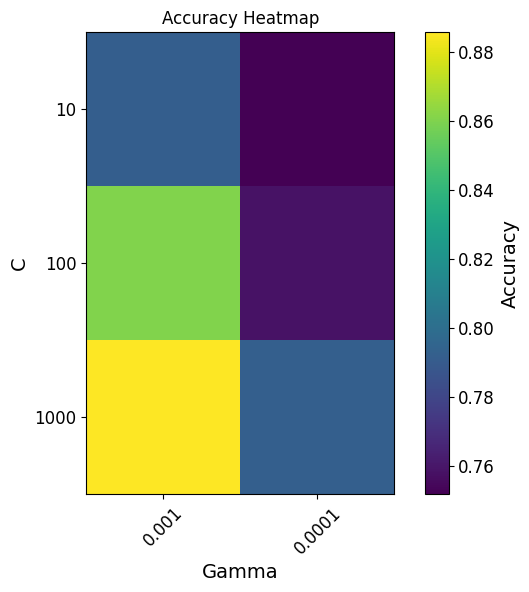

In [ ]:
from tqdm import tqdm

C_values = [10, 100, 1000]
gamma_values = [1e-3, 1e-4]
accuracy_matrix = np.zeros((len(C_values), len(gamma_values)))

with tqdm(total=len(C_values) * len(gamma_values), ncols=80, desc="Training") as pbar:
    for i, C in enumerate(C_values):
        for j, gamma in enumerate(gamma_values):
            svm = SVC(kernel="rbf", C=C, gamma=gamma)
            svm.fit(x_train_svm, y_train_svm)
            y_pred = svm.predict(x_test_svm)
            accuracy = accuracy_score(y_test_svm, y_pred)
            accuracy_matrix[i, j] = accuracy
            pbar.update(1)  

# accuracy heatmap
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xticks(np.arange(len(gamma_values)), gamma_values, rotation=45)
plt.yticks(np.arange(len(C_values)), C_values)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Heatmap')
plt.show()
